In [1]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    min_distance = 0.5  # Minimum distance constraint
    
    for i in range(num_points):
        # Generate the points in different locations to unbias learning
        x_beginning = None
        y_beginning = None
        if i % 4 == 0:
            x_beginning = 0
            y_beginning = 0
        elif i % 4 == 1:
            x_beginning = 1
            y_beginning = 0
        elif i % 4 == 2:
            x_beginning = 0
            y_beginning = 1
        else:
            x_beginning = 1
            y_beginning = 1

        data_point = []
        positions = []

        # Generate 3 particles with unique positions separated by at least 0.1
        for _ in range(3):
            while True:
                x = np.random.uniform(x_beginning, x_beginning + 1)
                y = np.random.uniform(y_beginning, y_beginning + 1)
                position = (x, y)

                # Check distance against all existing particles
                if all(np.sqrt((x - px)**2 + (y - py)**2) >= min_distance for px, py in positions):
                    positions.append(position)
                    break
            
            mass = np.random.uniform(1, 6)
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 10000 data points
num_points = 10000
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.097807, y = 0.214861, mass = 2.7346, force = [3.591264e+01, 1.803775e+01]]
  Particle 2: [x = 0.833217, y = 0.159732, mass = 5.7493, force = [-4.544488e+01, 2.865043e+01]]
  Particle 3: [x = 0.349148, y = 0.931362, mass = 4.5129, force = [9.532245e+00, -4.668817e+01]]

Data point 2:
  Particle 1: [x = 1.451024, y = 0.489238, mass = 3.6834, force = [4.046828e+01, 2.681734e+01]]
  Particle 2: [x = 1.998457, y = 0.025352, mass = 4.0620, force = [-2.721759e+01, 3.250522e+01]]
  Particle 3: [x = 1.647565, y = 0.979080, mass = 3.7163, force = [-1.325069e+01, -5.932256e+01]]

Data point 3:
  Particle 1: [x = 0.362669, y = 1.039097, mass = 3.0652, force = [3.984509e+01, 4.781746e+01]]
  Particle 2: [x = 0.494116, y = 1.555221, mass = 4.7013, force = [6.149114e+00, -7.131478e+01]]
  Particle 3: [x = 0.956866, y = 1.008349, mass = 3.1580, force = [-4.599421e+01, 2.349732e+01]]



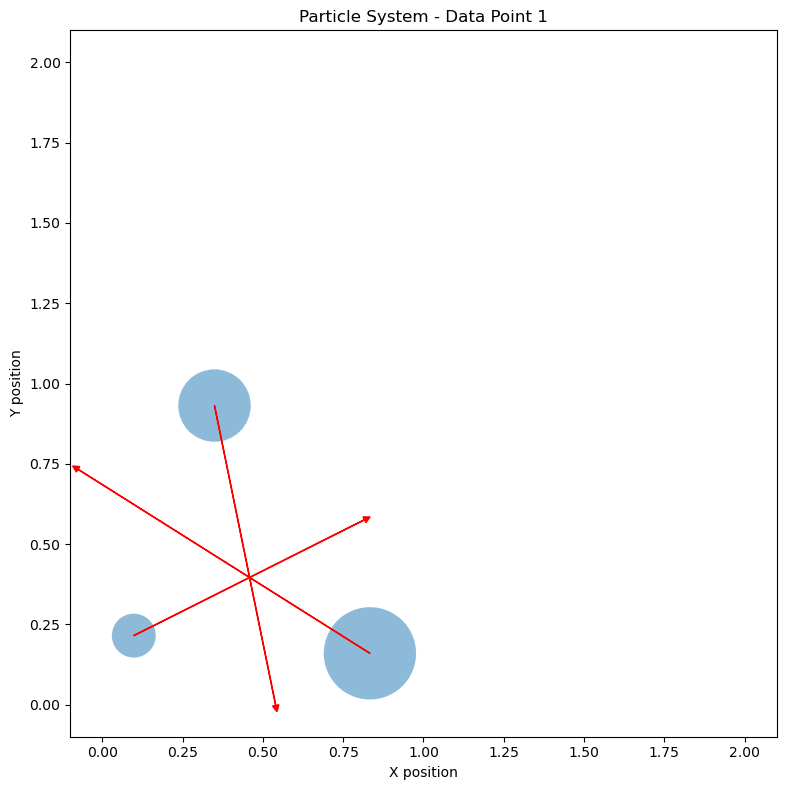

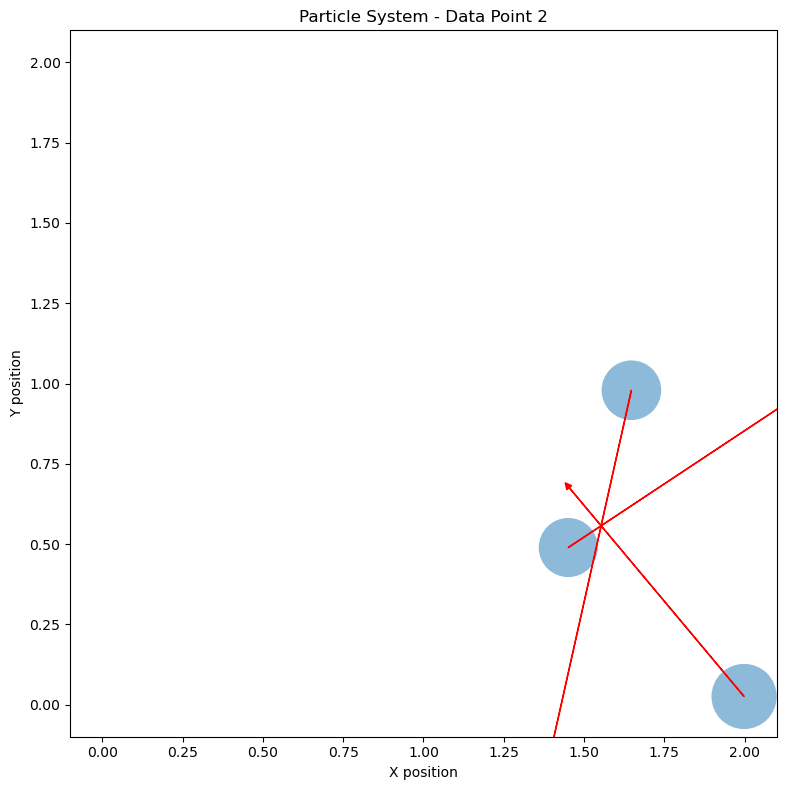

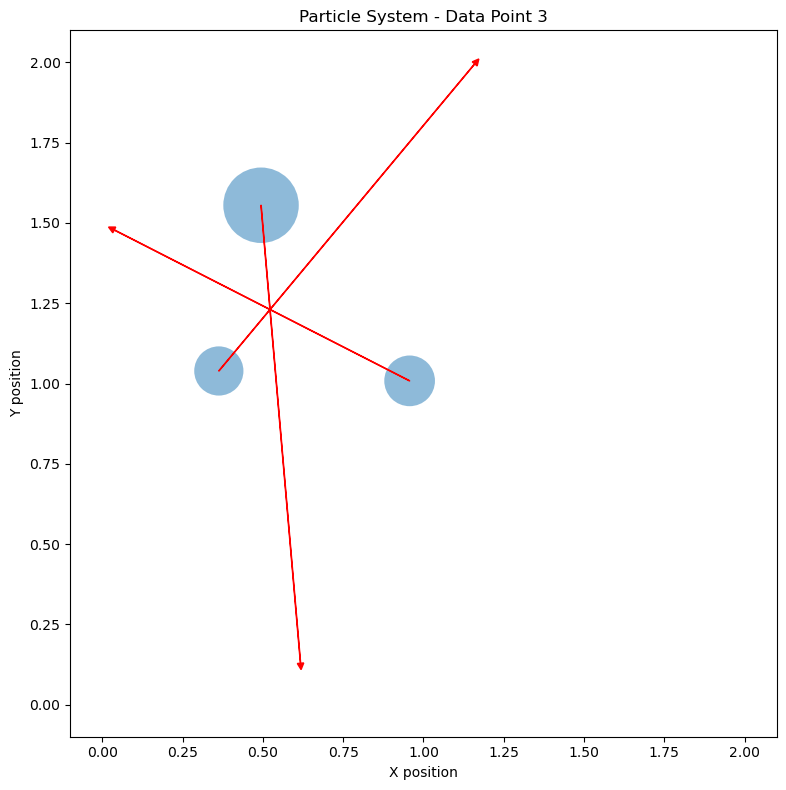

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 2.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = mass / 40  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 64),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        out = self.mlp(tmp)
        return out

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        return edge_attr

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.1621, 0.0731, 0.8134],
        [0.5089, 0.6248, 0.0496],
        [0.3088, 0.8493, 0.7926]])
Input:
tensor([[0.1621, 0.0731, 0.8134],
        [0.5089, 0.6248, 0.0496],
        [0.3088, 0.8493, 0.7926]])

Output (forces):
tensor([[ 0.2587, -0.4474],
        [ 0.2557, -0.4466],
        [ 0.2592, -0.4471]], grad_fn=<ScatterAddBackward0>)


In [4]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.09780718412391975, 0.21486068540688052, 2.7346251995045137, [35.91263893389177, 18.037747742405294]], [0.8332171340526137, 0.1597324282156639, 5.749279479832003, [-45.444883434174926, 28.650425916672724]], [0.3491480197208958, 0.9313620809239289, 4.512946479050122, [9.532244500283156, -46.68817365907802]]]
[[1.451024213166873, 0.48923774498424866, 3.683391563871803, [40.468279527433566, 26.81733739232459]], [1.9984572041376905, 0.02535187285243856, 4.062039188367357, [-27.217588059747587, 32.50521844869298]], [1.6475653100932657, 0.9790797906006682, 3.7162967050803806, [-13.250691467685979, -59.32255584101757]]]


tensor([[0.0978, 0.2149, 2.7346],
        [0.8332, 0.1597, 5.7493],
        [0.3491, 0.9314, 4.5129]])
tensor([[1.4510, 0.4892, 3.6834],
        [1.9985, 0.0254, 4.0620],
        [1.6476, 0.9791, 3.7163]])


tensor([[ 35.9126,  18.0377],
        [-45.4449,  28.6504],
        [  9.5322, -46.6882]])
tensor([[ 40.4683,  26.8173],
        [-27.2176,  32.5052],
        [-13.25

Using device: cuda
Epoch [1/100], Loss: 1054.3645, Learning Rate: 0.0200000000
Epoch [2/100], Loss: 204.4484, Learning Rate: 0.0200000000
Epoch [3/100], Loss: 46.9653, Learning Rate: 0.0200000000
Epoch [4/100], Loss: 15.2157, Learning Rate: 0.0200000000
Epoch [5/100], Loss: 12.3358, Learning Rate: 0.0200000000
Epoch [6/100], Loss: 9.0379, Learning Rate: 0.0200000000
Epoch [7/100], Loss: 9.2348, Learning Rate: 0.0200000000
Epoch [8/100], Loss: 10.2652, Learning Rate: 0.0200000000
Epoch [9/100], Loss: 10.1126, Learning Rate: 0.0200000000
Epoch [10/100], Loss: 7.6320, Learning Rate: 0.0180000000
Epoch [11/100], Loss: 4.5219, Learning Rate: 0.0180000000
Epoch [12/100], Loss: 8.7077, Learning Rate: 0.0180000000
Epoch [13/100], Loss: 5.1683, Learning Rate: 0.0180000000
Epoch [14/100], Loss: 8.1742, Learning Rate: 0.0180000000
Epoch [15/100], Loss: 9.8646, Learning Rate: 0.0180000000
Epoch [16/100], Loss: 6.9891, Learning Rate: 0.0180000000
Epoch [17/100], Loss: 8.7300, Learning Rate: 0.01800

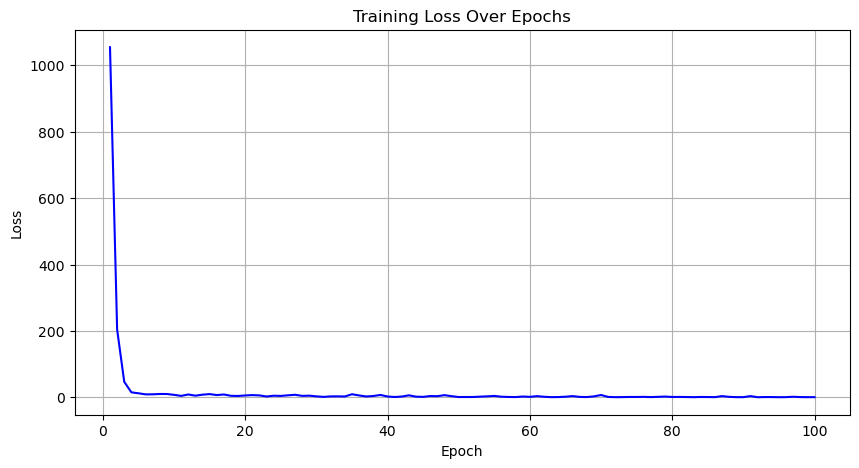

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Create a custom dataset that combines x (graph data) and y (labels)
class GraphDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data  # List of torch_geometric.data.Data objects
        self.y_data = y_data  # Corresponding labels

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]  # Get the graph data
        y = self.y_data[idx]  # Get the corresponding label
        x.y = y  # Assign the label to the graph data object
        return x

# Initialize the custom dataset
dataset = GraphDataset(x_dataset, y_dataset)

# Train-test split
train_size = 0.8  # Define the proportion of training data
x_train, x_test, y_train, y_test = train_test_split(
    dataset.x_data, dataset.y_data, train_size=train_size, random_state=42
)

# Create training and testing datasets
train_dataset = GraphDataset(x_train, y_train)
test_dataset = GraphDataset(x_test, y_test)

# Use PyTorch Geometric DataLoader to load data in batches
batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)  # Reduce LR by factor of gamma every step_size epochs

# Training loop
num_epochs = 100  # Define the number of epochs
loss_values = []  # List to store loss values for each epoch

for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    epoch_loss = 0.0  # Initialize epoch loss
    for batch in train_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)  # Store the average loss
    
    # Update the learning rate
    scheduler.step()  # Call the scheduler step at the end of each epoch
    
    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

print("Training complete!")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, color='b', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [6]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test loss and metrics
test_loss = 0.0  # Total loss over the test set
test_samples = 0  # Total number of samples

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        test_loss += loss.item() * batch.num_graphs  # Sum up batch loss, multiplied by number of graphs in the batch
        test_samples += batch.num_graphs  # Accumulate the total number of graphs

# Calculate the average test loss
avg_test_loss = test_loss / test_samples

print(f'Average Test Loss: {avg_test_loss:.4f}')

Average Test Loss: 0.3716


In [7]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset[:6]):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

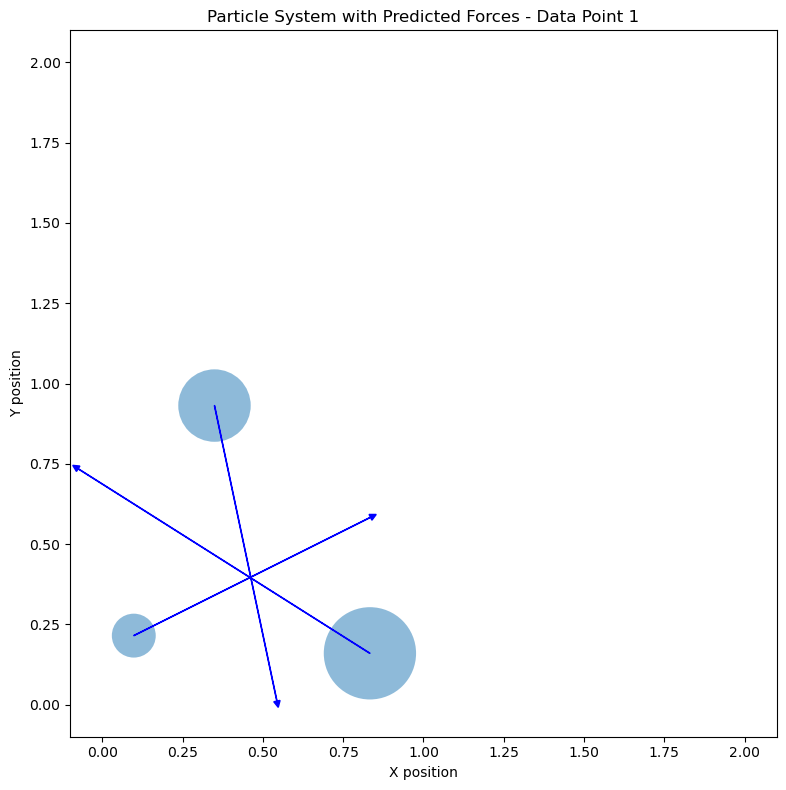

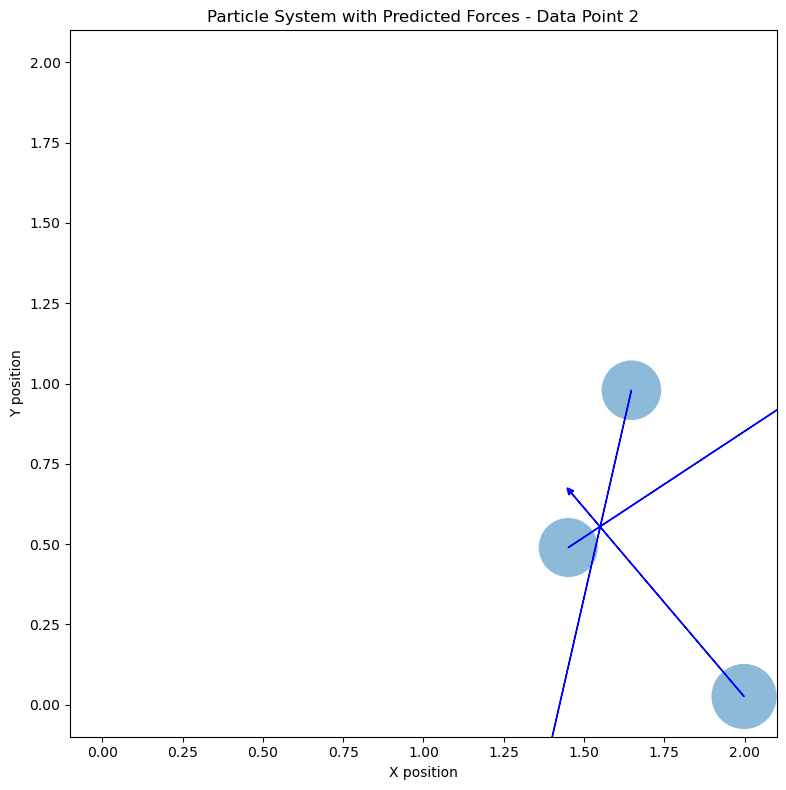

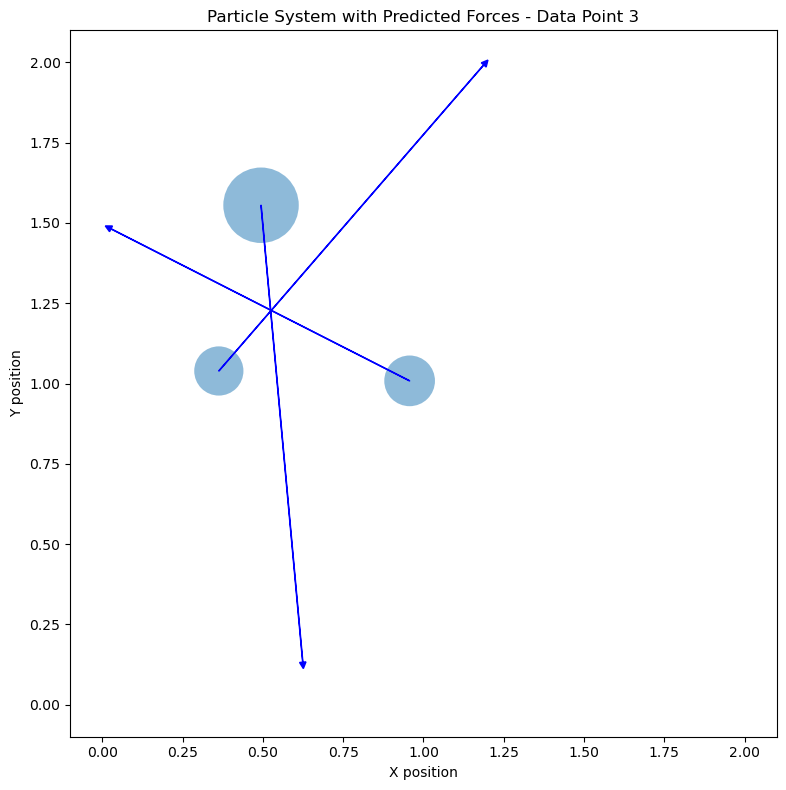

In [8]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 2.1)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = mass / 40  # Scale radius
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)

In [9]:
# Organize the data for PySR
input_data = []
predicted_forces = []
for i, data_point in enumerate(particle_dataset[:1000]):
    for j in range(0, 3):
        for k in range(0, 3):
            if j != k:
                particleA = data_point[j][:3]
                particleB = data_point[k][:3]
                input_tensor = torch.tensor(particleA + particleB, dtype=torch.float32)
                input_data.append(input_tensor)
                predicted_forces.append(model.edge_model.mlp(input_tensor.cuda()))

# Convert lists to NumPy arrays
input_data = np.vstack(input_data)
predicted_forces = np.vstack([tensor.cpu().detach().numpy() for tensor in predicted_forces])

<Figure size 640x480 with 0 Axes>

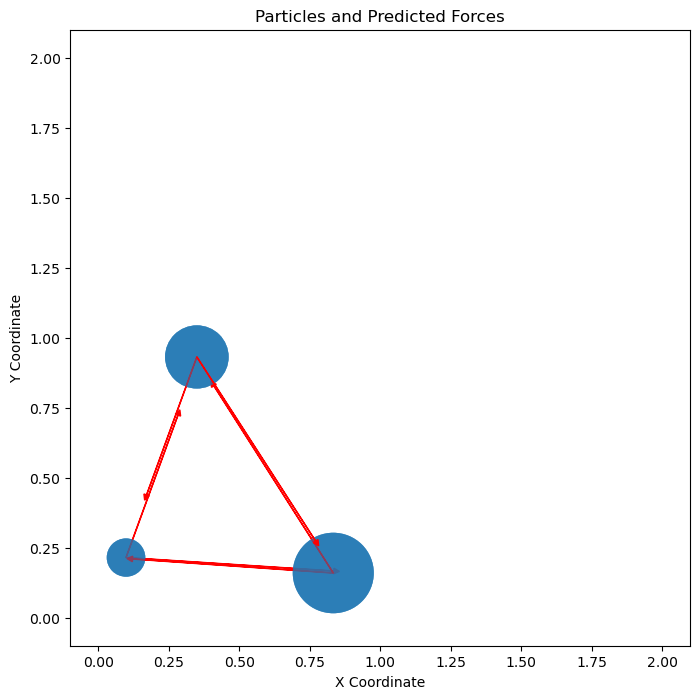

<Figure size 640x480 with 0 Axes>

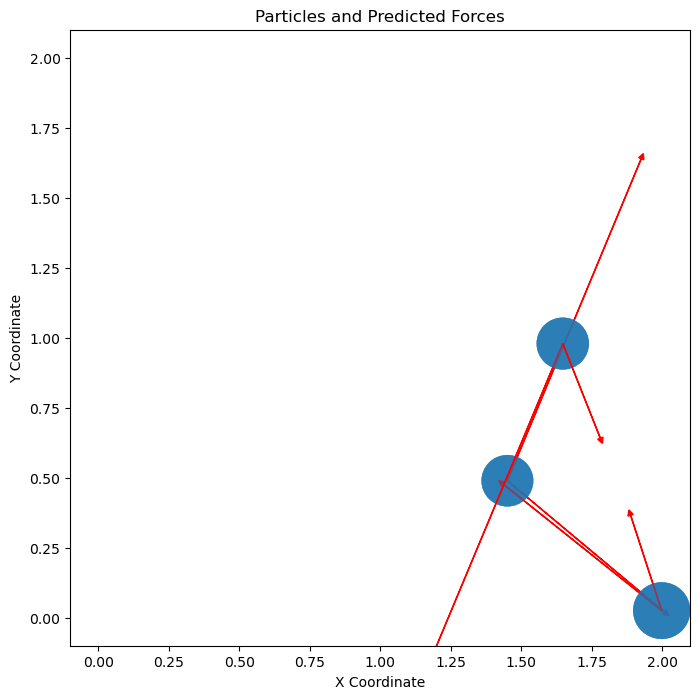

<Figure size 640x480 with 0 Axes>

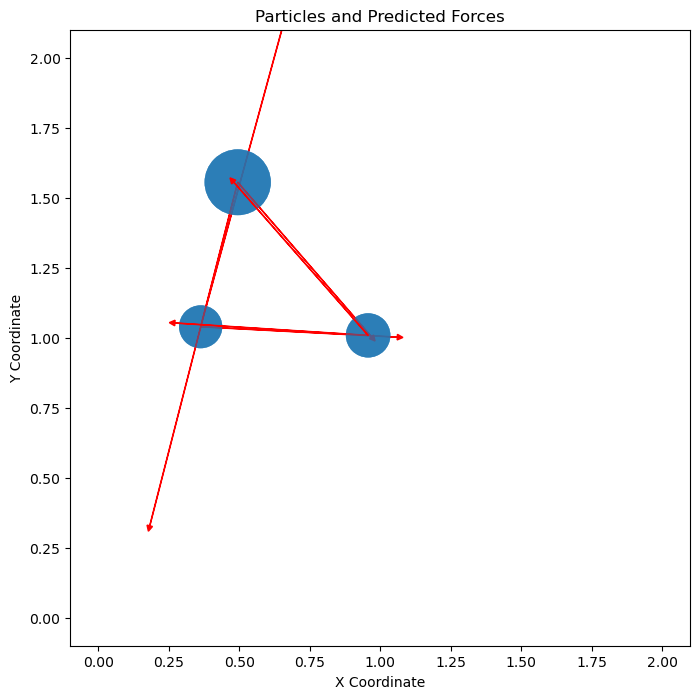

<Figure size 640x480 with 0 Axes>

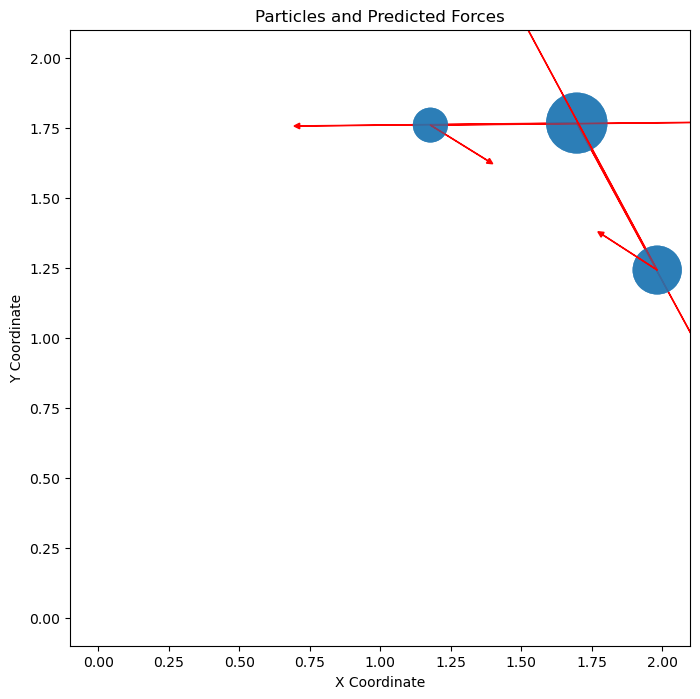

<Figure size 640x480 with 0 Axes>

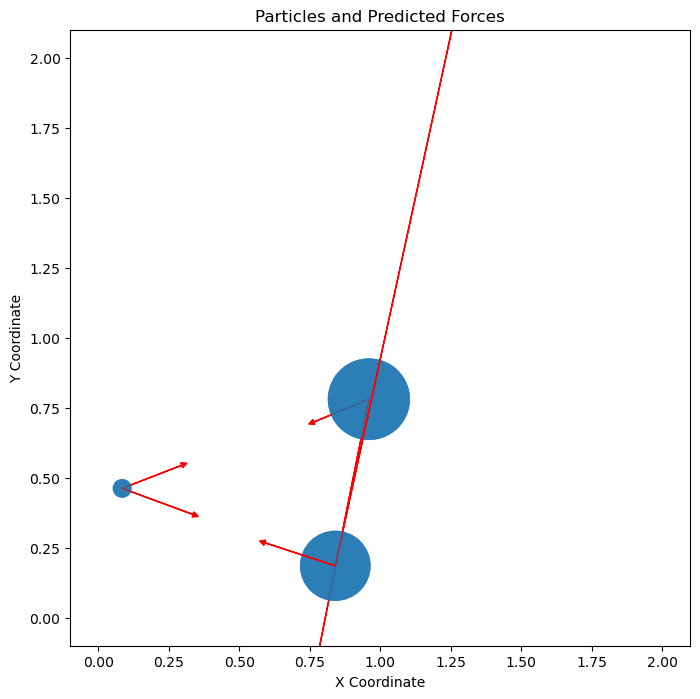

In [10]:
# Sample input data and predicted forces from the provided examples
n_samples = 30
input_data_sample = input_data[:n_samples]  # Extracting the first n_samples samples
predicted_forces_sample = predicted_forces[:n_samples]  # Extracting the first n_samples predicted forces


for k in range(0, len(input_data_sample), 6):
    # Create a new figure for each plot
    plt.figure()
    plt.figure(figsize=(8, 8))

    for i in range(k, k + 6):

        # Set plot limits
        plt.xlim(-0.1, 2.1)
        plt.ylim(-0.1, 2.1)

        # Extract particle data
        x1, y1, mass1, x2, y2, mass2 = input_data_sample[i]
        Fx, Fy = predicted_forces_sample[i]

        # Calculate the magnitude of the force
        force_magnitude = np.sqrt(Fx**2 + Fy**2)
        
        # Plot particles as a circles
        radius = mass1 / 40
        circle = plt.Circle((x1, y1), radius=radius, fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        radius = mass2 / 40
        circle = plt.Circle((x2, y2), radius=radius, fill=True, alpha=0.5)
        plt.gca().add_artist(circle)

        # Scale down the force arrow for visibility
        scale_factor = 0.1  # Adjust this value to change the arrow size

        # Draw force vector on Particle A (scaled down)
        plt.arrow(x1, y1, Fx / 40, Fy / 40, 
                head_width=0.02, head_length=0.02, fc='r', ec='r')

    # Set plot properties
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Particles and Predicted Forces')
    plt.show()

In [11]:
# Add a new column to the input data with the distances between particles
distances = []
for i in range(len(input_data)):
    x1, y1, mass1, x2, y2, mass2 = input_data[i]
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    distances.append(distance)

# Convert distances to a numpy array and add as a new column
distances = np.array(distances).reshape(-1, 1)
input_data_with_distances = np.hstack((input_data, distances))

In [13]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "-","*", "/"],
    unary_operators=["sqrt"],
)

# model.fit(input_data_with_distances[:5000], predicted_forces[:5000])

/home/polg24/anaconda3/envs/tfg_env/lib/python3.12/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 2.650e+04
Head worker occupation: 39.4%
Progress: 67 / 1200 total iterations (5.583%)
Best equations for output 1
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           6.237e+02  7.971e+00  y₀ = sqrt(x₃)
3           6.081e+02  2.532e-02  y₀ = x₅ * x₃
4           6.079e+02  3.542e-04  y₀ = x₃ / sqrt(x₀)
5           5.559e+02  8.942e-02  y₀ = (x₃ - x₀) * x₅
7           3.626e+02  2.136e-01  y₀ = ((x₃ - x₀) * x₅) * x₅
9           2.496e+02  1.867e-01  y₀ = (((x₃ - x₀) / x₆) * x₂) * x₅
11          7.620e+01  5.933e-01  y₀ = ((x₃ - x₀) * (x₅ * x₂)) / (x₆ + -0.27211)
13          2.019e-01  2.967e+00  y₀ = ((x₃ - x₀) * (((x₂ / x₆) / x₆) * x₅)) / x₆
15          1.706e-01  8.438e-02  y₀ = ((x₃ - (x₀ + -0.0029748)) * (((x₂ / x₆) / x₆) * x₅)) / x₆
---------------------------------------------------------------------------------------------------
Best

PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                                 x3   
	1         0.009994                                            x5 * x3   
	2         0.000354                                      x3 / sqrt(x0)   
	3         0.713355                           (x0 - x3) / -0.029260106   
	4         0.145952                     ((x0 - x3) / -0.03492063) / x6   
	5         0.185035                 (((x3 - x0) * 8.101572) * x5) / x6   
	6         0.830774         ((x3 - x0) * (x5 * x2)) / (x6 + -0.406256)   
	7   >>>>  2.486493         ((x3 - x0) * (((x2 / x6) / x6) * x5)) / x6   
	8         0.089517  (((x3 - x0) * (x5 * ((x2 / x6) / x6))) - -0.12...   
	9         0.032290  (((x3 - x0) * (x5 * (((x2 / x6) / x6) + 0.0385...   
	10        0.004759  0.12657511 + (((((x5 * (x2 - -0.012078785)) / ...   
	
	          loss  complexity  
	0   620.379000           1  
	1   608.101440           3  
	2   607.886050           4  
	3   297.862640           5  
	4   222.455750           7  
	5   153.647000           9  
	6    29.169075          11  
	7     0.201921          13  
	8     0.168822          15  
	9     0.158264          17  
	10    0.156765          19  
], [
	    pick     score                                           equation  \
	0         0.000000                                                 x4   
	1         0.008918                                            x4 * x5   
	2         0.004146                                      sqrt(x2 / x1)   
	3         0.688411                               (x4 - x1) * 34.71708   
	4         0.138856                     ((x4 - x1) / 0.035925806) / x6   
	5         0.186197                 ((x4 - x1) * x5) * (7.970479 / x6)   
	6         1.250116       (x2 * ((x4 - x1) * x5)) / (x6 + -0.38945487)   
	7   >>>>  2.230364         ((((x5 / x6) * (x4 - x1)) * x2) / x6) / x6   
	8         0.000378  (((x2 * ((x4 - x1) * (x5 / x6))) / x6) / x6) -...   
	9         0.001584  (((((((x4 - x1) - -0.0005536389) * x2) / x6) /...   
	10        0.002013  (((((x4 - x1) / x6) * (x5 / x6)) * x2) / x6) -...   
	
	          loss  complexity  
	0   616.382570           1  
	1   605.485900           3  
	2   602.981000           4  
	3   302.921840           5  
	4   229.467960           7  
	5   158.122540           9  
	6    12.976467          11  
	7     0.149929          13  
	8     0.149816          15  
	9     0.149342          17  
	10    0.148743          19  
]]